In [8]:
import os
import time
import copy
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset, TensorDataset, Subset
from torchvision import transforms, datasets
from matplotlib.gridspec import GridSpec
import torch.optim as optim
import time
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np



In [2]:
print("Is MPS available?", torch.backends.mps.is_available())

# Set device
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Using device:", device)

Is MPS available? True
Using device: mps


In [3]:
# Directories for the dataset
image_directory = '/Users/sogandghasemi/Documents/uni/RL/project/data2'
no_tumor_path = os.path.join(image_directory, 'no')
yes_tumor_path = os.path.join(image_directory, 'yes')

# Initialize dataset and labels lists
dataset = []
labels = []

# Fixed image size (e.g., 224x224)
image_size = (224, 224)




In [4]:
# Function to process images
def process_images(folder_path, label):
    # Make sure we're using the global variables
    global dataset, labels
    
    for image_name in os.listdir(folder_path):
        try:
            image_path = os.path.join(folder_path, image_name)
            with Image.open(image_path) as img:
                # Resize image to fixed size and convert to grayscale
                img_resized = img.resize(image_size).convert('L')
                # Convert image to a numpy array
                img_array = np.array(img_resized)
                # Reshape to add channel dimension (1 for grayscale)
                img_array = img_array.reshape(image_size[0], image_size[1], 1)
                # Append to dataset and labels
                dataset.append(img_array)
                labels.append(label)
        except Exception as e:
            print(f"Error loading image {image_name}: {e}")

# Process 'no' images
process_images(no_tumor_path, label=0)

# Process 'yes' images
process_images(yes_tumor_path, label=1)

# Only AFTER all images are processed, convert lists to numpy arrays
dataset = np.array(dataset)
labels = np.array(labels)
# Normalize pixel values to range [0,1]
dataset = dataset / 255.0

print(f"Dataset shape: {dataset.shape}")
print(f"Labels shape: {labels.shape}")

# Split the data into train, validation, and test sets
# First, split into temporary train and test
X_temp, X_test, y_temp, y_test = train_test_split(
    dataset, labels, test_size=0.2, random_state=42
)

# Then split the temporary train into actual train and validation
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42  # 0.25 * 0.8 = 0.2, so validation is 20% of total
)

# Convert data to PyTorch tensors
X_train = torch.FloatTensor(X_train).permute(0, 3, 1, 2)  # Change to channels first
X_val = torch.FloatTensor(X_val).permute(0, 3, 1, 2)
X_test = torch.FloatTensor(X_test).permute(0, 3, 1, 2)

y_train = torch.LongTensor(y_train)
y_val = torch.LongTensor(y_val)
y_test = torch.LongTensor(y_test)

# Create data loaders
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

# Print the shapes for verification
print(f"Training set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")
print(f"Test set: {X_test.shape}")


Dataset shape: (3000, 224, 224, 1)
Labels shape: (3000,)
Training set: torch.Size([1800, 1, 224, 224])
Validation set: torch.Size([600, 1, 224, 224])
Test set: torch.Size([600, 1, 224, 224])


In [5]:
class DeeperCNN(nn.Module):
    def __init__(self):
        super(DeeperCNN, self).__init__()
        self.features = nn.Sequential(
            # First Conv Block
            nn.Conv2d(1, 32, kernel_size=3),  
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            # Second Conv Block
            nn.Conv2d(32, 64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            # Third Conv Block
            nn.Conv2d(64, 64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 26 * 26, 64), #64 * 26 * 26: final output size
            nn.Dropout(0.5),
            nn.Linear(64, 2)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [6]:
def train_model(model, train_loader, val_loader, epochs=100, lr=0.0001, patience=20):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    criterion = nn.CrossEntropyLoss()  #loss function
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-3)  
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5, verbose=True) #learning rate scheduler: we start from 0.0001 and g

    history = {'train_acc': [], 'val_acc': [], 'train_loss': [], 'val_loss': []}
    best_val_loss = float('inf')
    early_stopping_counter = 0

    for epoch in range(epochs):
        model.train()
        train_loss, correct, total = 0, 0, 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_acc = 100. * correct / total
        train_loss /= len(train_loader)
        
        # Validation phase
        model.eval()
        val_loss, correct, total = 0, 0, 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
        
        val_acc = 100. * correct / total
        val_loss /= len(val_loader)

        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)

        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")

        scheduler.step(val_loss)

        # Early stopping mechanism with patience=20
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), "best_model.pth")
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1
            if early_stopping_counter >= patience:
                print("Early stopping triggered after no improvement for 20 epochs!")
                break

    # Plot Accuracy & Loss Graphs
    plt.figure(figsize=(12, 5))
    
    # Plot Training & Validation Loss
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss', color='blue')
    plt.plot(history['val_loss'], label='Validation Loss', color='red')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss Curve")
    plt.legend()
    
    # Plot Training & Validation Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train Accuracy', color='blue')
    plt.plot(history['val_acc'], label="Validation Accuracy", color='red')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.title("Accuracy Curve")
    plt.legend()
    
    plt.show()
    
    return history

Training Deeper CNN...


/opt/anaconda3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/100 - Train Loss: 0.6095 | Train Acc: 68.06% | Val Loss: 0.4817 | Val Acc: 78.50%
Epoch 2/100 - Train Loss: 0.5209 | Train Acc: 75.33% | Val Loss: 0.4550 | Val Acc: 80.17%
Epoch 3/100 - Train Loss: 0.4915 | Train Acc: 77.78% | Val Loss: 0.4305 | Val Acc: 82.17%
Epoch 4/100 - Train Loss: 0.4531 | Train Acc: 79.67% | Val Loss: 0.3970 | Val Acc: 83.17%
Epoch 5/100 - Train Loss: 0.4221 | Train Acc: 81.61% | Val Loss: 0.3550 | Val Acc: 85.67%
Epoch 6/100 - Train Loss: 0.3711 | Train Acc: 83.06% | Val Loss: 0.3294 | Val Acc: 87.17%
Epoch 7/100 - Train Loss: 0.3410 | Train Acc: 85.33% | Val Loss: 0.2899 | Val Acc: 89.17%
Epoch 8/100 - Train Loss: 0.3086 | Train Acc: 87.33% | Val Loss: 0.2714 | Val Acc: 89.83%
Epoch 9/100 - Train Loss: 0.2871 | Train Acc: 88.39% | Val Loss: 0.2816 | Val Acc: 86.67%
Epoch 10/100 - Train Loss: 0.2790 | Train Acc: 88.50% | Val Loss: 0.2398 | Val Acc: 90.83%
Epoch 11/100 - Train Loss: 0.2381 | Train Acc: 91.11% | Val Loss: 0.2104 | Val Acc: 92.33%
Epoch 12

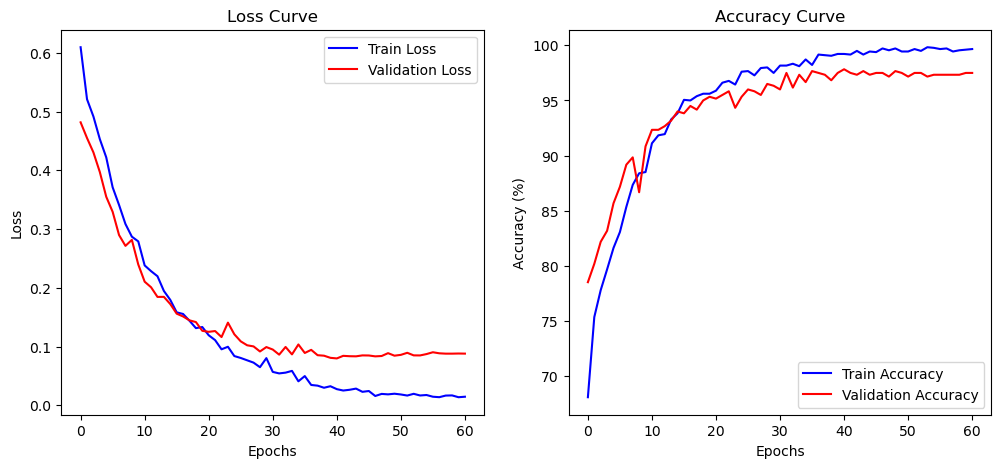

Model saved as tumor_classifier.pth


In [7]:

print("Training Deeper CNN...")
deeper_model = DeeperCNN()
deeper_history = train_model(deeper_model, train_loader, val_loader, epochs=100, lr=0.0001, patience=20)

# Save the trained model for later fine-tuning
model_path = "tumor_classifier.pth"
torch.save(deeper_model.state_dict(), model_path)
print(f"Model saved as {model_path}")


Loading best model for testing...


/var/folders/q4/n5kvp8wn7g55334d0nyggx500000gn/T/ipykernel_7032/4232406545.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  deeper_model.load_state_dict(torch.load("best

Test Loss: 0.1437 | Test Acc: 95.50%


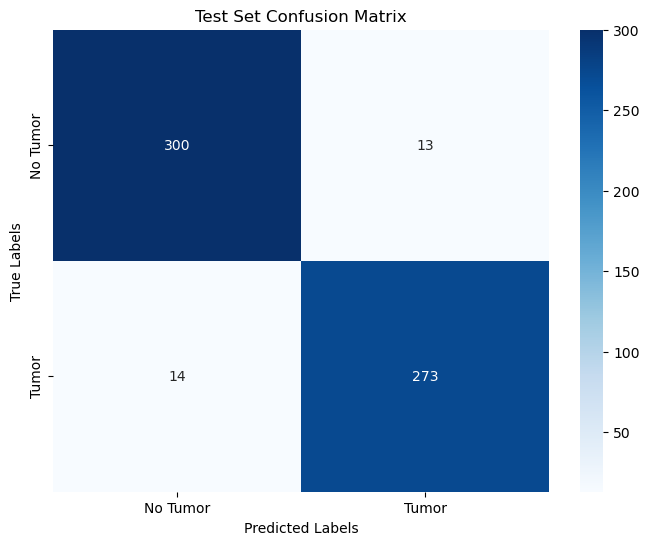


Classification Report:
              precision    recall  f1-score   support

    No Tumor       0.96      0.96      0.96       313
       Tumor       0.95      0.95      0.95       287

    accuracy                           0.95       600
   macro avg       0.95      0.95      0.95       600
weighted avg       0.95      0.95      0.95       600

Final test accuracy: 95.50%


In [9]:
def test_model(model, test_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    
    test_loss = 0
    correct = 0
    total = 0
    
    criterion = nn.CrossEntropyLoss()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    test_loss /= len(test_loader)
    test_acc = 100. * correct / total
    
    print(f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.2f}%")
    
    # Create confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=["No Tumor", "Tumor"],
                yticklabels=["No Tumor", "Tumor"])
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Test Set Confusion Matrix")
    plt.show()
    
    # Print classification report
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, 
                              target_names=["No Tumor", "Tumor"]))
    
    return test_acc, cm

# Load the best model
print("Loading best model for testing...")
deeper_model.load_state_dict(torch.load("best_model.pth"))
deeper_model.to(device)

# Test on test set
test_accuracy, test_confusion = test_model(deeper_model, test_loader)
print(f"Final test accuracy: {test_accuracy:.2f}%")

In [2]:
from torchvision import datasets, transforms
from torch.utils.data import Subset

# Define image transformations
data_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

# Define dataset directory
data_dir = "/Users/sogandghasemi/Documents/uni/RL/project/New_data"
dataset = datasets.ImageFolder(root=data_dir, transform=data_transforms)

# Output classes detected
print("Classes detected:", dataset.classes)  # Expected output: ['glioma', 'meningioma']

# Count how many images belong to each class
glioma_count = sum(1 for _, label in dataset if label == dataset.class_to_idx['glioma'])
meningioma_count = sum(1 for _, label in dataset if label == dataset.class_to_idx['meningioma'])

# Print the counts for each class
print(f"Number of Glioma images: {glioma_count}")
print(f"Number of Meningioma images: {meningioma_count}")

# Optionally, if you want to filter and create a new subset for binary classes (glioma, meningioma)
binary_indices = [i for i, (_, label) in enumerate(dataset) if label in [0, 1]]
binary_dataset = Subset(dataset, binary_indices)

# Total images after filtering
print(f"Total images after filtering: {len(binary_dataset)}")


Classes detected: ['glioma', 'meningioma']
Number of Glioma images: 1321
Number of Meningioma images: 1339
Total images after filtering: 2660


In [5]:
def create_tasks(dataset, num_tasks=2, task_split=0.5):
  
    # Get the total indices of the dataset
    indices = list(range(len(dataset)))
    
    # Shuffle the indices to ensure randomness
    np.random.shuffle(indices)
    
    tasks = []
    # Calculate how many images we want per task for training and testing
    task_size = len(dataset) // num_tasks
    
    for i in range(num_tasks):
        # Split the dataset into disjoint parts for each task
        start_idx = i * task_size
        end_idx = (i + 1) * task_size
        
        # Get the indices for this task
        task_indices = indices[start_idx:end_idx]
        
        # Split each task into support (train) and query (test) sets
        train_idx, test_idx = train_test_split(task_indices, test_size=task_split)
        
        # Create DataLoader for support (train) and query (test) sets
        train_loader = DataLoader(Subset(dataset, train_idx), batch_size=8, shuffle=True)
        test_loader = DataLoader(Subset(dataset, test_idx), batch_size=8, shuffle=True)
        
        # Append the task loaders
        tasks.append((train_loader, test_loader))
    
    return tasks



tasks = create_tasks(binary_dataset)

In [ ]:
def evaluate_model(model, tasks):
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for train_loader, test_loader in tasks:
            for x, y in test_loader:
                x, y = x.to(device), y.to(device)
                preds = model(x)
                loss = nn.CrossEntropyLoss()(preds, y)
                val_loss += loss.item()
                correct += (preds.argmax(dim=1) == y).sum().item()
                total += y.size(0)

    model.train()
    return val_loss / len(tasks), correct / total

In [6]:
def maml_train(model, meta_optimizer, tasks, num_iterations=1000, num_inner_steps=3, inner_lr=0.01):
    train_losses = []
    val_losses = []
    val_accuracies = []
    
    # Store best model state
    best_val_loss = float('inf')
    best_model_state = None
    
    # Learning rate scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        meta_optimizer, 
        mode='min', 
        factor=0.5,
        patience=5,
        verbose=True
    )

    for iteration in range(num_iterations):
        meta_optimizer.zero_grad()
        meta_loss = 0
        
        # Select 3 tasks minimum for stability
        selected_tasks = random.sample(tasks, k=min(3, len(tasks)))
                
        for i, (train_loader, test_loader) in enumerate(selected_tasks):
            fast_weights = [w.clone() for w in model.parameters()]
            
            # Inner-loop adaptation (Support Set)
            for step in range(num_inner_steps):
                for x, y in train_loader:
                    x, y = x.to(device), y.to(device)
                    preds = model(x)
                    loss = nn.CrossEntropyLoss()(preds, y)
                    grads = torch.autograd.grad(loss, fast_weights, create_graph=False, allow_unused=True)
                    fast_weights = [w - inner_lr * g if g is not None else w for w, g in zip(fast_weights, grads)]
            
            # Outer-loop evaluation (Query Set)
            for x, y in test_loader:
                x, y = x.to(device), y.to(device)
                preds = model(x)
                loss = nn.CrossEntropyLoss()(preds, y)
                meta_loss += loss
        
        # Meta update
        meta_loss.backward()
        meta_optimizer.step()
        
        # Compute validation metrics every iteration for complete data
        val_loss, val_acc = evaluate_model(model, tasks)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        train_losses.append(meta_loss.item())
        
        # Update scheduler every iteration
        scheduler.step(val_loss)
        
        # Still track best model, but don't stop early
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = copy.deepcopy(model.state_dict())
        
        # Custom display frequency
        should_display = False
        if iteration < 500 and (iteration + 1) % 10 == 0:  # Every 10 steps until 500
            should_display = True
        elif iteration < 700 and (iteration + 1) % 20 == 0:  # Every 20 steps from 500 to 700
            should_display = True
        elif (iteration + 1) % 50 == 0:  # Every 50 steps from 700 to 1000
            should_display = True
        elif iteration == num_iterations - 1:  # Always display last iteration
            should_display = True
            
        if should_display:
            print(f"[Iteration {iteration+1}/{num_iterations}] - Meta Loss: {meta_loss.item():.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc * 100:.2f}%")
    
    # Load the best model after all iterations
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print(f"Training completed. Loaded best model with validation loss: {best_val_loss:.4f}")
    
    # Save the best model to disk
    torch.save(model.state_dict(), 'best_glioma_meningioma_model.pt')
    print("Best model saved to 'best_glioma_meningioma_model.pt'")
    
    # Plot Training and Validation Metrics with all data points
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    
    # X-axis is simply iteration number, as we computed metrics for every iteration
    iterations = list(range(1, len(val_losses) + 1))
    
    plt.plot(iterations, val_losses, label='Validation Loss')
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(iterations, [acc * 100 for acc in val_accuracies], label='Validation Accuracy (%)')
    plt.xlabel('Iterations')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('training_curves.png')
    plt.show()
    
    print(f"Final validation accuracy: {val_accuracies[-1] * 100:.2f}%")
    return train_losses, val_losses, val_accuracies

/opt/anaconda3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[Iteration 10/1000] - Meta Loss: 308.3083, Val Loss: 160.2685, Val Acc: 63.01%
[Iteration 20/1000] - Meta Loss: 279.8228, Val Loss: 135.1082, Val Acc: 75.75%
[Iteration 30/1000] - Meta Loss: 254.6497, Val Loss: 122.8319, Val Acc: 77.14%
[Iteration 40/1000] - Meta Loss: 232.8245, Val Loss: 110.9214, Val Acc: 79.14%
[Iteration 50/1000] - Meta Loss: 207.0127, Val Loss: 100.7803, Val Acc: 82.41%
[Iteration 60/1000] - Meta Loss: 190.9598, Val Loss: 91.4322, Val Acc: 85.00%
[Iteration 70/1000] - Meta Loss: 170.6234, Val Loss: 81.7086, Val Acc: 86.58%
[Iteration 80/1000] - Meta Loss: 163.3409, Val Loss: 77.9157, Val Acc: 87.78%
[Iteration 90/1000] - Meta Loss: 153.1203, Val Loss: 73.9779, Val Acc: 88.61%
[Iteration 100/1000] - Meta Loss: 144.8881, Val Loss: 69.4575, Val Acc: 88.98%
[Iteration 110/1000] - Meta Loss: 140.8508, Val Loss: 65.5085, Val Acc: 89.92%
[Iteration 120/1000] - Meta Loss: 128.6244, Val Loss: 61.7433, Val Acc: 90.41%
[Iteration 130/1000] - Meta Loss: 123.7151, Val Loss: 58

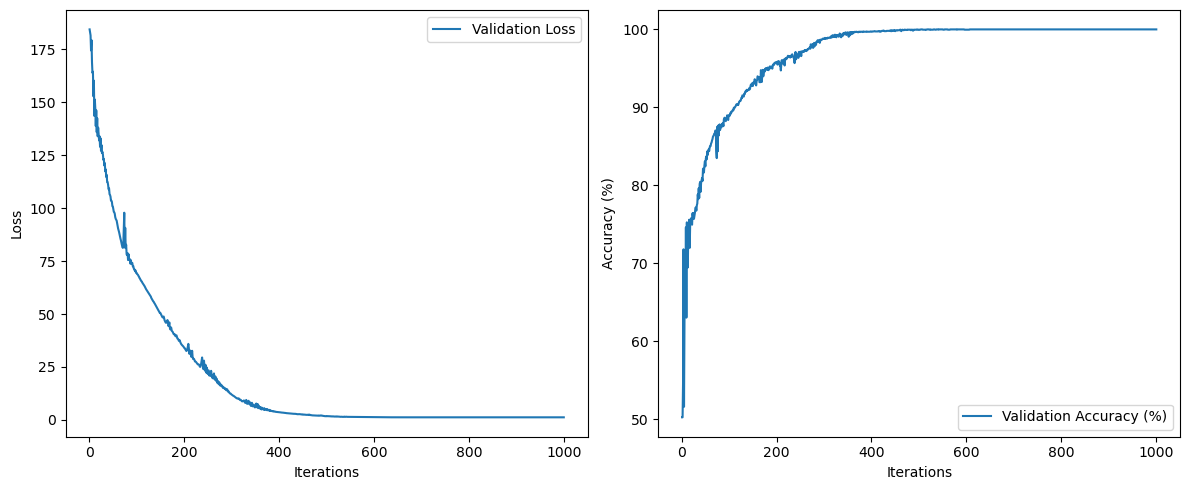

Final validation accuracy: 99.96%


([370.4690246582031,
  369.08123779296875,
  366.04608154296875,
  363.7128601074219,
  349.8830871582031,
  359.36474609375,
  339.10491943359375,
  329.8586730957031,
  331.5029296875,
  308.3082580566406,
  325.623046875,
  290.6670227050781,
  309.225830078125,
  302.3081359863281,
  285.07501220703125,
  297.20391845703125,
  275.69635009765625,
  291.2327575683594,
  273.74798583984375,
  279.8228454589844,
  275.6853942871094,
  269.2497863769531,
  271.3719177246094,
  265.2912292480469,
  271.55511474609375,
  259.5112609863281,
  267.11737060546875,
  257.2403564453125,
  259.0874328613281,
  254.649658203125,
  250.30337524414062,
  253.12059020996094,
  244.86712646484375,
  245.07366943359375,
  240.5287628173828,
  241.2311248779297,
  236.5558319091797,
  235.05059814453125,
  229.755859375,
  232.8245086669922,
  225.40475463867188,
  222.30747985839844,
  226.82781982421875,
  218.90170288085938,
  218.55850219726562,
  218.3609619140625,
  214.85342407226562,
  213.87

In [8]:

tasks = create_tasks(binary_dataset, num_tasks=2, task_split=0.5)

# Initialize model with reduced input size
model = DeeperCNN(input_size=(64, 64)).to(device)

# Meta-optimizer with slightly higher learning rate for faster convergence
meta_optimizer = optim.Adam(model.parameters(), lr=0.002, weight_decay=1e-5)

# Run MAML training with optimized settings (removed patience parameter)
maml_train(
    model, 
    meta_optimizer, 
    tasks, 
    num_iterations=1000,
    num_inner_steps=3,
    inner_lr=0.01
)

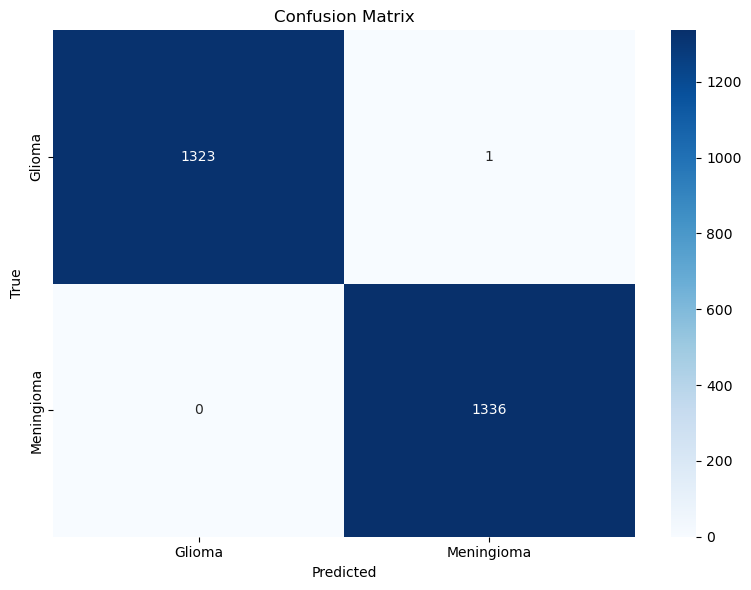

Overall Accuracy: 0.9996
Glioma Sensitivity: 0.9992
Glioma Specificity: 1.0000


In [11]:
def plot_confusion_matrix(model, tasks):
    
    
    model.eval()
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for train_loader, test_loader in tasks:
            for x, y in test_loader:
                x, y = x.to(device), y.to(device)
                outputs = model(x)
                _, predicted = torch.max(outputs.data, 1)
                
                all_preds.extend(predicted.cpu().numpy())
                all_targets.extend(y.cpu().numpy())
    
    # Compute confusion matrix
    cm = confusion_matrix(all_targets, all_preds)
    
    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Glioma', 'Meningioma'],
                yticklabels=['Glioma', 'Meningioma'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.savefig('confusion_matrix.png')
    plt.show()
    
    # Calculate metrics
    accuracy = (cm[0, 0] + cm[1, 1]) / cm.sum()
    sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])  # True positive rate for Glioma
    specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])  # True negative rate for Glioma
    
    print(f"Overall Accuracy: {accuracy:.4f}")
    print(f"Glioma Sensitivity: {sensitivity:.4f}")
    print(f"Glioma Specificity: {specificity:.4f}")
    
    return cm

# Call this function after training completes
cm = plot_confusion_matrix(model, tasks)